In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import root_mean_squared_error

In [2]:
rating_df = pd.read_csv('data/rating_shortened.csv')
rating_df = rating_df[rating_df.rating!=-1]
rating_df = rating_df.groupby(by=['user_id','anime_id']).mean().reset_index()
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741989 entries, 0 to 1741988
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 39.9 MB


In [3]:
rating_df.describe()

,user_id,anime_id,rating
count,1.741989e+06,1.741989e+06,1.741989e+06
mean,3.646120e+04,7.404219e+03,8.151622e+00
std,2.106427e+04,7.585783e+03,1.501881e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.868200e+04,1.132000e+03,7.000000e+00
50%,3.602500e+04,5.081000e+03,8.000000e+00
75%,5.469000e+04,1.132100e+04,9.000000e+00
max,7.351600e+04,3.387100e+04,1.000000e+01


In [4]:
num_users = len(rating_df['user_id'].unique())
num_items = len(rating_df['anime_id'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` animes")

There are total `66974` of users and `893` animes


### transforming rating data

In [5]:
user_encoder, anime_encoder = LabelEncoder(), LabelEncoder()
rating_scaler = MinMaxScaler()
rating_df.user_id = user_encoder.fit_transform(rating_df.user_id.values)
rating_df.anime_id = anime_encoder.fit_transform(rating_df.anime_id.values)
rating_df.rating = rating_scaler.fit_transform(rating_df.rating.values.reshape(-1, 1))

In [6]:
rating_df

,user_id,anime_id,rating
0,0,447,1.000000
1,0,553,1.000000
2,0,559,1.000000
3,1,562,1.000000
4,2,2,0.777778
...,...,...,...
1741984,66972,571,0.666667
1741985,66972,580,0.777778
1741986,66972,603,0.666667
1741987,66972,714,1.000000


In [7]:
rating_df.describe()

,user_id,anime_id,rating
count,1.741989e+06,1.741989e+06,1.741989e+06
mean,3.322747e+04,3.353756e+02,7.946246e-01
std,1.920803e+04,2.460303e+02,1.668756e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.698000e+04,9.500000e+01,6.666667e-01
50%,3.285500e+04,3.310000e+02,7.777778e-01
75%,4.986200e+04,5.480000e+02,8.888889e-01
max,6.697300e+04,8.920000e+02,1.000000e+00


In [8]:
rating_df_copy=rating_df.copy()

In [9]:
rating_df_copy = rating_df_copy.sample(frac=1, random_state=42)
rating_df_copy

,user_id,anime_id,rating
1544476,59141,559,0.888889
1331660,50919,310,0.666667
198036,7404,707,0.888889
107317,4085,683,0.888889
1636535,62748,7,0.888889
...,...,...,...
259178,10200,661,0.777778
1414414,53946,74,1.000000
131932,5038,3,0.888889
671155,25233,637,0.777778


### creating latent features with the neural network

In [10]:
x = rating_df_copy[["user_id", "anime_id"]].values
y = rating_df_copy["rating"].values

train_indices = int(0.8 * rating_df_copy.shape[0])
test_indices = int(0.9 * rating_df_copy.shape[0])
x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:test_indices],
    x[test_indices:],
    y[:train_indices],
    y[train_indices:test_indices],
    y[test_indices:],
)
x_val.shape

(174199, 2)

In [11]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=32, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [12]:
model = RecommenderNet(num_users=num_users, num_items=num_items, 
                       embedding_size=32)

In [14]:
early_stopping=keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', 
                                             mode='min', 
                                             patience=1, 
                                             restore_best_weights=True, 
                                             verbose=1)

In [15]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
## - call model.fit() to train the model
history=model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), 
                  batch_size=80, epochs=10, shuffle=True, 
                  callbacks=[early_stopping])

Epoch 1/10
17420/17420 [==============================] - 433s 25ms/step - loss: 0.0459 - root_mean_squared_error: 0.2135 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1553
Epoch 2/10
17420/17420 [==============================] - 429s 25ms/step - loss: 0.0224 - root_mean_squared_error: 0.1483 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1463
Epoch 3/10
17420/17420 [==============================] - 440s 25ms/step - loss: 0.0208 - root_mean_squared_error: 0.1426 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1442
Epoch 4/10
17420/17420 [==============================] - 660s 38ms/step - loss: 0.0204 - root_mean_squared_error: 0.1409 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1433
Epoch 5/10
17420/17420 [==============================] - 515s 30ms/step - loss: 0.0203 - root_mean_squared_error: 0.1405 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1437
Epoch 5: early stopping


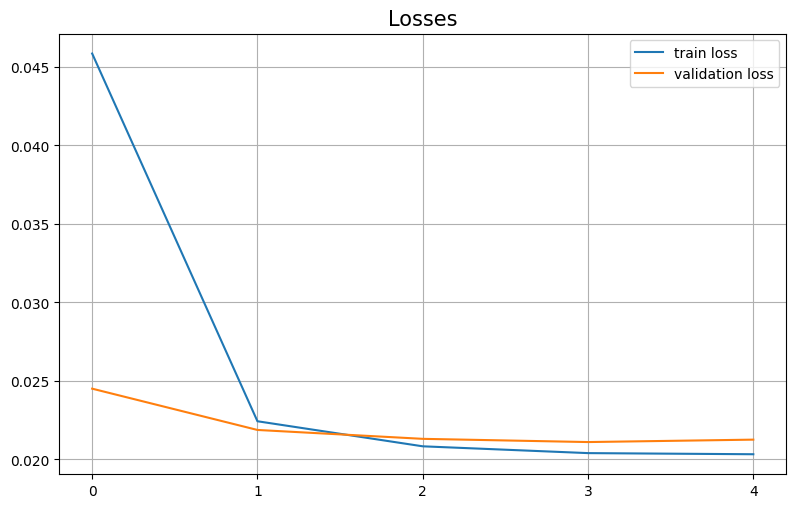

In [16]:
fig, axs = plt.subplots(figsize=(8, 5))
plt.tight_layout()
axs.plot(history.history['loss'], label='train loss')
axs.plot(history.history['val_loss'], label='validation loss')
axs.set_title("Losses", size=15)
axs.set_xticks([e for e in range(5)])
plt.grid()
axs.legend(loc="best", prop={'size': 10});

In [17]:
model.evaluate(x_test, y_test)

5444/5444 [==============================] - 24s 4ms/step - loss: 0.0222 - root_mean_squared_error: 0.1472


[0.02223888412117958, 0.14723871648311615]

In [18]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embe  multiple                  2143168   
 dding)                                                          
                                                                 
 user_bias (Embedding)       multiple                  66974     
                                                                 
 item_embedding_layer (Embe  multiple                  28576     
 dding)                                                          
                                                                 
 item_bias (Embedding)       multiple                  893       
                                                                 
Total params: 2239611 (8.54 MB)
Trainable params: 2239611 (8.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (66974, 32)


In [20]:
anime_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Anime features shape: {anime_latent_features.shape}")

Anime features shape: (893, 32)


In [21]:
user_latent_features_df=pd.DataFrame(user_latent_features)
user_latent_features_df.columns=[f'UFeature{i}' for i in range(32)]
user_latent_features_df.index=user_encoder.classes_
user_latent_features_df.index.name='user_id'
user_latent_features_df

,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,...,UFeature22,UFeature23,UFeature24,UFeature25,UFeature26,UFeature27,UFeature28,UFeature29,UFeature30,UFeature31
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.002293,0.005720,0.008767,0.001190,0.001890,-0.008762,-0.001398,0.002519,0.010608,0.011795,...,0.006752,-0.004074,-0.011482,-0.013401,0.015123,-0.000572,-0.005248,-0.001895,0.010829,0.009276
2,-0.003766,0.000848,-0.009270,-0.006474,-0.002256,0.007590,-0.003637,0.002460,0.004033,-0.006464,...,-0.001814,-0.000579,0.000471,-0.004449,-0.005763,-0.006932,-0.003989,-0.002015,0.012648,0.004132
3,-0.026575,-0.010439,0.014416,0.004375,-0.013350,-0.026773,-0.003597,0.019597,-0.002202,-0.018111,...,0.050347,0.017578,-0.017443,0.041598,0.012553,-0.008606,0.015527,0.002963,0.004255,0.011045
5,0.035114,0.036159,-0.048489,-0.029029,-0.038731,-0.023813,0.030614,-0.024356,-0.011369,0.022483,...,0.039402,-0.010242,-0.010681,0.030282,0.011035,-0.014971,-0.001458,-0.002045,-0.000964,-0.007960
7,0.008596,0.008084,-0.010157,0.035001,0.045445,0.011750,0.003981,-0.000933,0.026105,-0.009083,...,-0.031823,0.006525,-0.008705,-0.019264,-0.012706,0.026360,0.001911,-0.000769,0.011614,-0.028798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73511,0.012891,0.005041,0.003045,0.006435,0.002678,0.002538,-0.003181,0.000981,-0.007504,-0.006789,...,0.006063,-0.003523,0.000450,-0.011047,-0.006036,-0.002557,0.006250,0.002764,-0.002712,0.006601
73512,0.011007,0.002294,-0.006026,0.000195,0.003193,-0.010158,0.007254,-0.000588,-0.003505,-0.008338,...,0.007764,0.000390,-0.008512,0.005902,-0.003786,0.004327,-0.005403,-0.008167,-0.011153,-0.004784
73513,0.025549,0.004730,-0.006872,-0.008866,-0.015747,0.014699,0.002935,-0.012750,0.010975,-0.008672,...,0.014158,0.002278,0.003299,0.016409,-0.008656,0.013642,0.007464,0.000517,0.003850,-0.008501


In [22]:
user_latent_features_df.to_csv("data/user_latent_features.csv", index=True)

In [23]:
anime_latent_features_df=pd.DataFrame(anime_latent_features)
anime_latent_features_df.columns=[f'AFeature{i}' for i in range(32)]
anime_latent_features_df.index=anime_encoder.classes_
anime_latent_features_df.index.name='anime_id'
anime_latent_features_df

,AFeature0,AFeature1,AFeature2,AFeature3,AFeature4,AFeature5,AFeature6,AFeature7,AFeature8,AFeature9,...,AFeature22,AFeature23,AFeature24,AFeature25,AFeature26,AFeature27,AFeature28,AFeature29,AFeature30,AFeature31
anime_id,,,,,,,,,,,,,,,,,,,,,
1,-0.006071,0.006747,0.038891,-0.002308,-0.008532,0.062928,-0.020590,0.012602,-0.008296,-0.016850,...,-0.007854,0.053166,0.049449,-0.085748,-0.018955,0.001756,-0.019223,-0.023822,-0.017619,0.050091
6,0.066077,0.024743,0.043613,0.048623,0.019925,0.048202,-0.035134,0.026282,-0.004704,-0.002812,...,-0.004958,0.050299,0.011284,-0.024192,0.002925,0.012635,0.049684,-0.003837,-0.033145,0.019443
20,0.037703,-0.012476,0.019329,0.012866,-0.023218,0.067184,0.009204,0.017766,0.031295,-0.000931,...,-0.021990,-0.032122,-0.011456,0.008259,0.022296,-0.015772,0.015400,0.055953,0.013152,-0.000455
30,-0.043746,0.034761,-0.004984,-0.027197,0.048214,-0.021342,-0.035840,-0.006775,-0.006423,0.059106,...,0.035542,0.010328,-0.013628,-0.038136,-0.021444,-0.045919,0.012466,0.037233,0.009838,0.070496
43,-0.064434,0.006790,0.001532,0.033336,0.012835,0.007047,-0.002605,-0.077510,-0.039552,0.038693,...,0.029697,0.021680,0.051198,-0.023483,-0.032458,-0.014712,-0.001412,0.011642,-0.063293,0.019280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33474,0.030361,0.048258,-0.050739,-0.018576,0.042147,-0.002548,0.000083,0.025703,-0.044007,-0.005479,...,-0.003305,-0.021605,-0.015240,-0.012805,-0.041181,-0.024776,0.054392,-0.025677,-0.018342,0.001465
33546,0.072246,0.072709,0.021053,0.002029,0.045316,0.000779,0.012450,-0.023864,-0.015466,-0.017205,...,-0.030616,0.012330,0.019112,-0.036015,-0.053833,-0.048577,-0.036542,-0.036301,-0.010301,-0.039029
33606,0.046427,0.011475,0.067458,-0.008575,0.004869,-0.012701,0.104463,0.038773,0.008829,-0.027854,...,0.017256,0.030869,-0.014372,-0.017087,-0.005844,0.004965,0.001160,0.022912,-0.022721,-0.016804


In [24]:
anime_latent_features_df.to_csv("data/anime_latent_features.csv", index=True)

### regression on the latent features

In [25]:
user_latent_features_df = pd.read_csv('data/user_latent_features.csv', index_col='user_id')
anime_latent_features_df = pd.read_csv('data/anime_latent_features.csv', index_col='anime_id')

In [26]:
rating_df = pd.read_csv('data/rating_shortened.csv')
rating_df = rating_df[rating_df.rating!=-1]
rating_df = rating_df.groupby(by=['user_id','anime_id']).mean().reset_index()
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741989 entries, 0 to 1741988
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 39.9 MB


In [27]:
merged_df = pd.merge(rating_df, user_latent_features_df, how='left', left_on='user_id', right_on='user_id')
merged_df = pd.merge(merged_df, anime_latent_features_df, how='left', left_on='anime_id', right_on='anime_id')
merged_df

,user_id,anime_id,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,AFeature22,AFeature23,AFeature24,AFeature25,AFeature26,AFeature27,AFeature28,AFeature29,AFeature30,AFeature31
0,1,8074,10.0,-0.002293,0.005720,0.008767,0.001190,0.001890,-0.008762,-0.001398,...,0.046931,0.028822,0.007027,-0.027012,0.055176,-0.032041,0.010281,0.032566,0.010641,-0.016037
1,1,11617,10.0,-0.002293,0.005720,0.008767,0.001190,0.001890,-0.008762,-0.001398,...,0.023777,-0.027986,0.032297,-0.004848,0.047779,0.016787,-0.020976,0.035804,0.038512,0.009571
2,1,11757,10.0,-0.002293,0.005720,0.008767,0.001190,0.001890,-0.008762,-0.001398,...,0.038993,-0.020897,0.015710,0.016634,-0.000425,-0.043055,0.008829,-0.050148,-0.015195,-0.017040
3,2,11771,10.0,-0.003766,0.000848,-0.009270,-0.006474,-0.002256,0.007590,-0.003637,...,-0.048925,-0.009016,0.014374,-0.029224,0.030650,0.045980,0.015699,0.001507,0.015061,0.001384
4,3,20,8.0,-0.026575,-0.010439,0.014416,0.004375,-0.013350,-0.026773,-0.003597,...,-0.021990,-0.032122,-0.011456,0.008259,0.022296,-0.015772,0.015400,0.055953,0.013152,-0.000455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741984,73515,12461,7.0,0.019314,-0.025777,-0.016865,-0.006786,-0.019831,-0.018396,0.024167,...,-0.089264,0.073223,-0.038637,0.023953,0.010962,0.029508,-0.082373,-0.027630,-0.052688,0.012857
1741985,73515,13161,8.0,0.019314,-0.025777,-0.016865,-0.006786,-0.019831,-0.018396,0.024167,...,0.006910,0.025137,0.013847,-0.071025,-0.013732,-0.025391,0.035286,-0.045372,0.061853,-0.014739
1741986,73515,14345,7.0,0.019314,-0.025777,-0.016865,-0.006786,-0.019831,-0.018396,0.024167,...,0.029558,-0.010592,0.044927,-0.003143,-0.001550,-0.064275,-0.001173,-0.002667,0.063158,-0.000685
1741987,73515,22145,10.0,0.019314,-0.025777,-0.016865,-0.006786,-0.019831,-0.018396,0.024167,...,0.054620,-0.018552,-0.015251,-0.012432,0.059402,-0.015524,0.022492,0.006766,-0.061243,-0.001210


In [28]:
merged_df.isna().any().any()

False

In [29]:
X=merged_df[merged_df.columns[3:]].values
y=merged_df.rating.values

X.shape, y.shape

((1741989, 64), (1741989,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.1)

In [33]:
lr=LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred=lr.predict(X_test)
root_mean_squared_error(y_true=y_test, y_pred=y_pred)

1.482156132502022

In [35]:
param_grid={'alpha':[0.001, 0.1, 10, 1000],
            'l1_ratio':[0, 0.25, 0.5, 0.75, 1]}
model=ElasticNet()
grid_search=GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)

C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jade\AppData\Loca

GridSearchCV(cv=4, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 10, 1000],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [36]:
grid_search.best_params_

{'alpha': 0.001, 'l1_ratio': 0}

In [37]:
grid_search.best_score_

-2.2192770418076844

In [39]:
y_pred=grid_search.best_estimator_.predict(X_test)
root_mean_squared_error(y_true=y_test, y_pred=y_pred)

1.4865996746823045

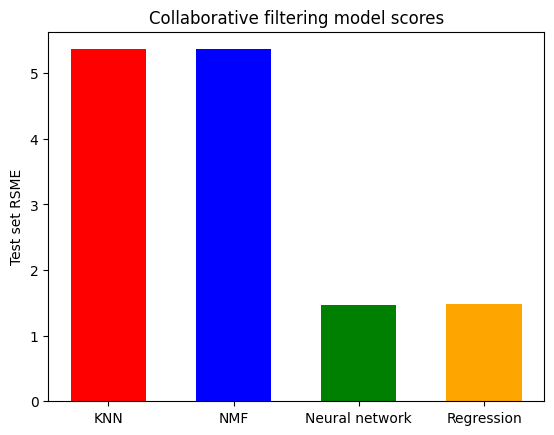

In [2]:
scores=pd.Series({'KNN':5.364490, 'NMF':5.364496, 'Neural network':1.472387, 'Regression':1.482156})
ax=plt.gca()
ax.bar(range(4), scores.values, width=0.6, color=['red', 'blue', 'green','orange']);
ax.set_xticks(range(4), scores.index);
ax.set_ylabel('Test set RSME')
ax.set_title('Collaborative filtering model scores');